<a href="https://colab.research.google.com/github/21Ovi/TensorFlow_/blob/main/04_Transfer_Learning_in_TensorFlow_02_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-Tuning

In the previous notebook, we cpvered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning : 

`Fine-Tuning`,

In [1]:
# Check if we're using a GPY
!nvidia-smi

Sat Apr 15 15:30:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions
In Previous notebooks, we've created a bunch of helper functins, now we could rewrite them all, however, this is tedious

So, it's a good idea to put functions you'll want to use again in a script you can download and import into notebooks( or elsewhere).

we've done this for some of the previous functions we've used previously here :

 https://raw.githubusercontent.com/21Ovi/Helper-Functions/main/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/21Ovi/Helper-Functions/main/helper_functions.py

--2023-04-15 15:30:33--  https://raw.githubusercontent.com/21Ovi/Helper-Functions/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10116 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.88K  --.-KB/s    in 0s      

2023-04-15 15:30:33 (59.7 MB/s) - ‘helper_functions.py’ saved [10116/10116]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

>**Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functins.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and applyu them to our own problem (recognizing images of food):
https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get 10% of training data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-04-15 15:30:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.197.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   196MB/s    in 0.8s    

2023-04-15 15:30:39 (196 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Checkout how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [6]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Checkout the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.27214287e+02 1.17214287e+02 1.25214287e+02]
   [1.25882652e+02 1.15882652e+02 1.23882652e+02]
   [1.25790817e+02 1.15790817e+02 1.23790817e+02]
   ...
   [1.59295914e+02 1.47295914e+02 1.49295914e+02]
   [1.60331650e+02 1.48331650e+02 1.50331650e+02]
   [1.54627563e+02 1.42627563e+02 1.44627563e+02]]

  [[1.24857147e+02 1.14857147e+02 1.22857147e+02]
   [1.23275513e+02 1.13275513e+02 1.21275513e+02]
   [1.26515305e+02 1.17301018e+02 1.22943878e+02]
   ...
   [1.58913269e+02 1.46913269e+02 1.48913269e+02]
   [1.59785736e+02 1.47785736e+02 1.49785736e+02]
   [1.58051025e+02 1.46051025e+02 1.48051025e+02]]

  [[1.28862244e+02 1.18647957e+02 1.26219383e+02]
   [1.28928574e+02 1.19928574e+02 1.24928574e+02]
   [1.26877556e+02 1.17877556e+02 1.22877556e+02]
   ...
   [1.61260193e+02 1.49260193e+02 1.52923447e+02]
   [1.58387711e+02 1.46387711e+02 1.48816284e+02]
   [1.57857132e+02 1.45857132e+02 1.48285706e+02]]

  ...

  [[1.20739845e+02 9.48163681e+01 6.85970306e+01]
   [1

## Model 0: Building a transfer learning model Feature Extraction using the Keras Functional API

The Sequential API is straight-forward, it runs our layers in sequential order.

But the Functional API gives us more flexibility with our models

In [11]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updating during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the output of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the input with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len (test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

16705208/16705208 [==============================] - 0s 0us/step


Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230415-153048
Epoch 1/5
24/24 [==============================] - 33s 350ms/step - loss: 1.9090 - accuracy: 0.3747 - val_loss: 1.3389 - val_accuracy: 0.7204
Epoch 2/5
24/24 [==============================] - 4s 134ms/step - loss: 1.1164 - accuracy: 0.7613 - val_loss: 0.9023 - val_accuracy: 0.8125
Epoch 3/5
24/24 [==============================] - 5s 175ms/step - loss: 0.8016 - accuracy: 0.8173 - val_loss: 0.6983 - val_accuracy: 0.8438
Epoch 4/5
24/24 [==============================] - 4s 136ms/step - loss: 0.6466 - accuracy: 0.8560 - val_loss: 0.6234 - val_accuracy: 0.8602
Epoch 5/5
24/24 [==============================] - 4s 136ms/step - loss: 0.5615 - accuracy: 0.8693 - val_loss: 0.5593 - val_accuracy: 0.8586


In [12]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 84ms/step - loss: 0.5635 - accuracy: 0.8544


[0.5635020732879639, 0.8543999791145325]

In [13]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [14]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [15]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


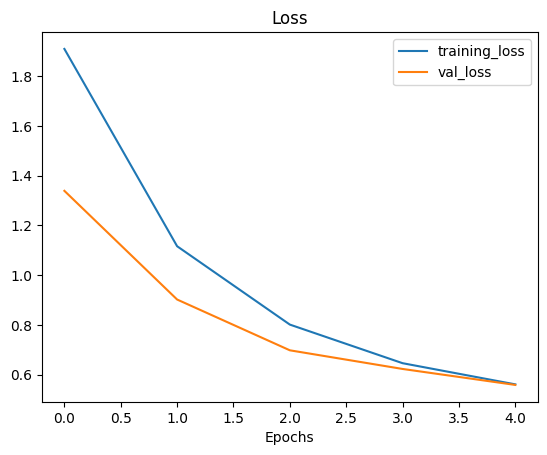

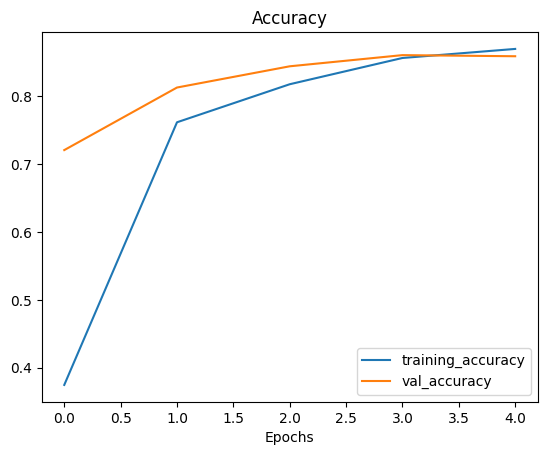

In [16]:
 # Check out our model's training curves
 plot_loss_curves(history_10_percent)

## Getting a feature vector from a traineed model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)

But then it passes through GlobalAveragePooling2D, it turns into (none, 1280)

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [17]:
# Define the input shape
Input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(Input_shape)
print(f"Random input tensor: \n {input_tensor}\n")

# Pass the ranodm tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D Global Average Pooled Random Tensor:\n{global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"shape of input tensor: {input_tensor.shape}")
print(f"Shape of global average pooled tensor : {global_average_pooled_tensor.shape}")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D Global Average Pooled Random Tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]

shape of input tensor: (1, 4, 4, 3)
Shape of global average pooled tensor : (1, 3)


In [18]:
# Let's repicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data but how does it go with 1% of the training data... how about we set up bunch of experiment to find out:

1. `model_1` - use feature transfer learning with 1% of the training data with data augmentaion
2. `model_2` - use feature extraction transfer learning with 10% of the training data augmentation
3 `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% training data with data augmentation

> 🔑 **Note** Throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistancy across evaluation metrics.

## Getting and preprocessing data for model_1

In [19]:
# Download an unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-04-15 15:31:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.20.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   168MB/s    in 0.8s    

2023-04-15 15:31:54 (168 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [21]:
# How many images we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'

In [22]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#3 Adding data augmentation right into the model

To Add data augmentation right into the model we can use the layers inside:

* tf.keras.layers.experimental.preprocessing()

Benifits of using data augmentation inside the model :

* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happes during training, so we can still export our whole model and usr it elsewhere

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficiemtMet's having rescaling built-in
], name="data_augmentation")

## Visualize our data augmentation layer (and see what happens to our data)

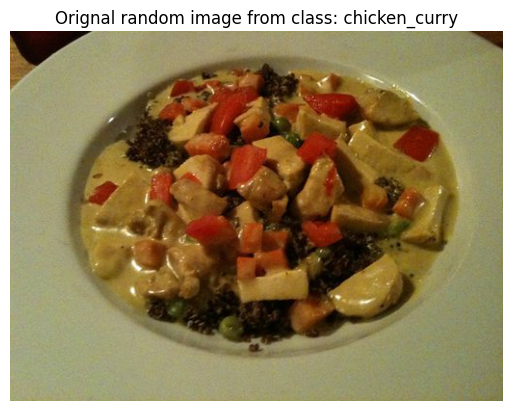

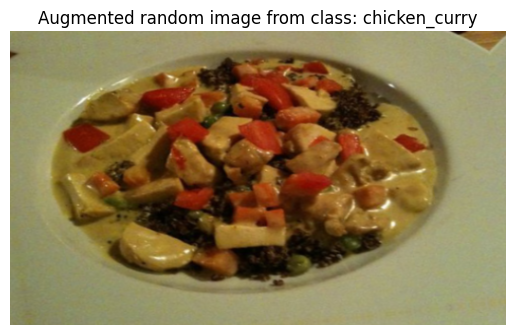

In [24]:
# View a random image and compare it to it's augmentaed version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_10_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot in the random image
img = mpimg.imread(random_image_path)

plt.imshow(img)
plt.title(f"Orignal random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [25]:
# Setup the input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layers
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output feature on the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230415-153200
Epoch 1/5
3/3 [==============================] - 13s 3s/step - loss: 2.3526 - accuracy: 0.1286 - val_loss: 2.2379 - val_accuracy: 0.1793
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.0780 - accuracy: 0.3143 - val_loss: 2.1046 - val_accuracy: 0.2632
Epoch 3/5
3/3 [==============================] - 7s 3s/step - loss: 1.9041 - accuracy: 0.4714 - val_loss: 1.9987 - val_accuracy: 0.3306
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7342 - accuracy: 0.5714 - val_loss: 1.9067 - val_accuracy: 0.4194
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.5563 - accuracy: 0.6857 - val_loss: 1.8165 - val_accuracy: 0.4786


In [26]:
# Check out model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [27]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 66ms/step - loss: 1.8095 - accuracy: 0.4620


[1.809484601020813, 0.4620000123977661]

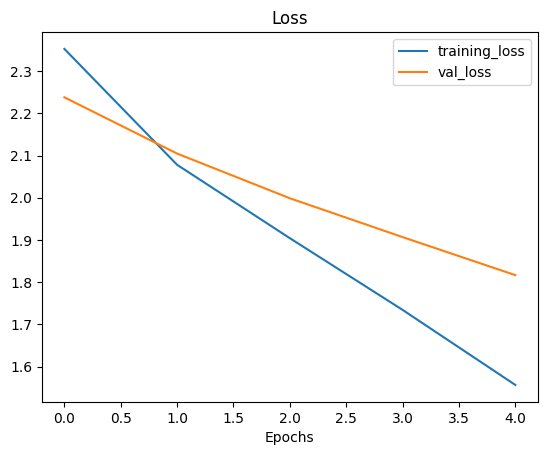

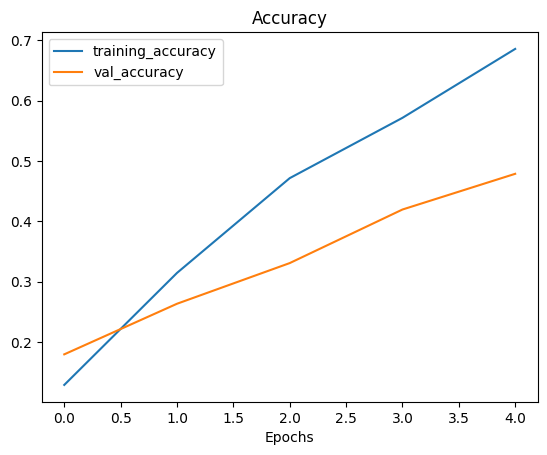

In [28]:
# How do the model with 1% of the data go with data augmentation looks
plot_loss_curves(history_1_percent)

## Model 2: Feature Extraction transfer learning model with 10% of the data and data augmentation

In [29]:
# Get 10% of data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2023-04-15 15:32:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   246MB/s    in 0.7s    

2023-04-15 15:32:43 (246 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [30]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [31]:
# How many images are ub direcotries
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [32]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_dir_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [33]:
# Create Model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import  preprocessing
from tensorflow.keras.models import Sequential

# Built data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficiemtMet's having rescaling built-in
], name="data_augmentation")

# Setup input shape to our model
imput_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input and outputs (including the layers in between)
input = layers.Input(shape=input_shape, name="input_shape")
x = data_augmentation(inputs) # augment our training images (augmentation does not occour on test data)
x = base_model(x, training=False) # Pass the augmented images to base model but keep it in inference mode, this also insures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [34]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a ModelCheckpoint callback

 The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off

In [35]:
# Set checkpoint path
checkpoint_path = "tehn_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # save each epoch
                                                         verbose=1)

### Fit model 2 passing the ModelChecpoint callback

In [36]:
# Fit the model saving checpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230415-154148
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9323 - accuracy: 0.3747
Epoch 1: saving model to tehn_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 24s 668ms/step - loss: 1.9323 - accuracy: 0.3747 - val_loss: 1.3703 - val_accuracy: 0.6891
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2889 - accuracy: 0.7093
Epoch 2: saving model to tehn_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 516ms/step - loss: 1.2889 - accuracy: 0.7093 - val_loss: 0.9497 - val_accuracy: 0.7944
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9725 - accuracy: 0.7667
Epoch 3: saving model to tehn_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 538ms/step - loss: 0.9725 - accuracy: 0.7667 - val_loss: 0.7533 - val_accuracy: 0.833

In [37]:
# model_0 results
model_0.evaluate(test_data)

79/79 [==============================] - 6s 65ms/step - loss: 0.5635 - accuracy: 0.8544


[0.5635020732879639, 0.8543999791145325]

In [39]:
# Check model_2 result on all test data
result_10_percent_data_aug = model_2.evaluate(test_data)
result_10_percent_data_aug

79/79 [==============================] - 6s 72ms/step - loss: 0.6040 - accuracy: 0.8528


[0.6040262579917908, 0.8528000116348267]

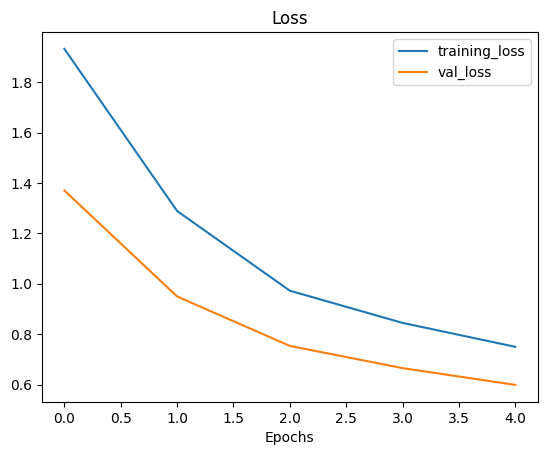

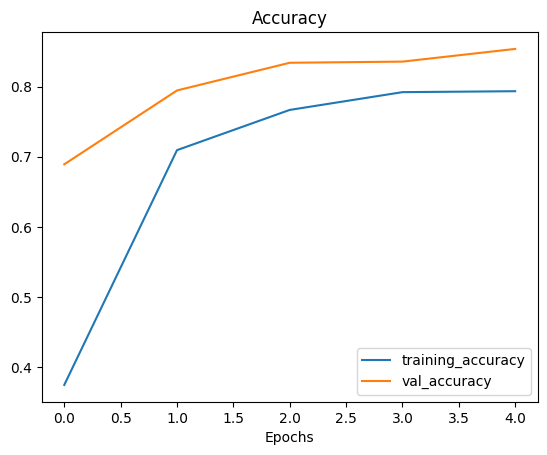

In [40]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)